(multilevel_hgf)=
# Parameters recovery, prior predictive and posterior predictive sampling

In [16]:
from numpy import loadtxt
import numpy as np
from ghgf.distribution import hgf_logp, HGFDistribution
from ghgf import load_data
from ghgf.response import binary_surprise
import jax.numpy as jnp
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

np.random.seed(123)

In this tutorial, we are going to demonstrate some forms of parameters recovery, prior predictive and posterior predictive sampling that can be a way to assess the strength of the model fitting.

## Continuous HGF
### Simulate a dataset

In [17]:
n_data = 6
dataset = []
for participant in range(n_data):
    input_data = []
    kappa_1 = 1.0
    omega_1 = -10.0
    omega_2 = -10.0
    mu_1 = 0.0
    mu_2 = 0.0
    pi_1 = 1e4
    pi_2 = 1e1
    
    # two-level hierarchical gaussian random walk
    for i in range(1000):
        
        # x2
        pi_2 = np.exp(omega_2)
        mu_2 = np.random.normal(mu_2, pi_2**.5)

        # x1
        pi_1 = np.exp(kappa_1 * mu_2 + omega_1)
        mu_1 = np.random.normal(mu_1, pi_1**.5)
        
        # input node
        u = np.random.normal(mu_1, 1e-4**.5)
        input_data.append(u)

    dataset.append(input_data)

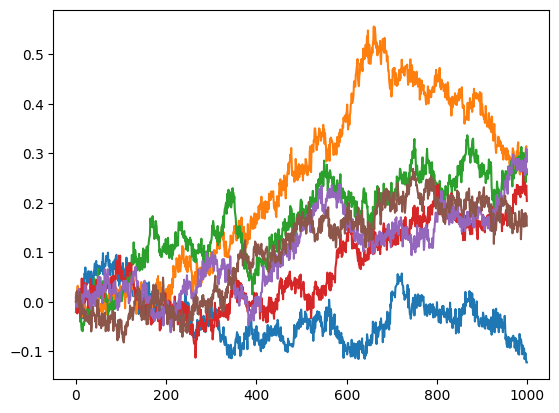

In [18]:
for rw in dataset:
    plt.plot(rw)

## Embedding a serie of HGFs in a graphical model

Here, we are goingin to estimate the parameter $omega_{1}$ from the time series created by the hierarchical random walks. All the time series were generated using $omega_{1} = -10.0$ and we want to see how the Bayesian inference can retrieve these values.

In [19]:
hgf_logp_op = HGFDistribution(
    n_levels=2,
    model_type="continuous",
    input_data=dataset,
)

In [20]:
with pm.Model() as model:
    
    # Priors
    #-------
    omega_1 = pm.Normal("omega_1", mu=0.0, sigma=2.0, shape=n_data)

    pm.Potential(
        "hgf_loglike",
        hgf_logp_op(
            omega_1=omega_1,
            omega_2=-10.0,
            omega_input=np.log(1e-4),
            rho_1=0.0,
            rho_2=0.0,
            pi_1=1e4,
            pi_2=1e1,
            mu_1=0.0,
            mu_2=0.0,
            kappa_1=1.0,
            bias=0.0,
            omega_3=jnp.nan,
            rho_3=jnp.nan,
            pi_3=jnp.nan,
            mu_3=jnp.nan,
            kappa_2=jnp.nan
        ),
    )

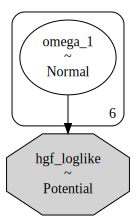

In [21]:
pm.model_to_graphviz(model)

In [22]:
with model:
    idata = pm.sample(chains=4, cores=4, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


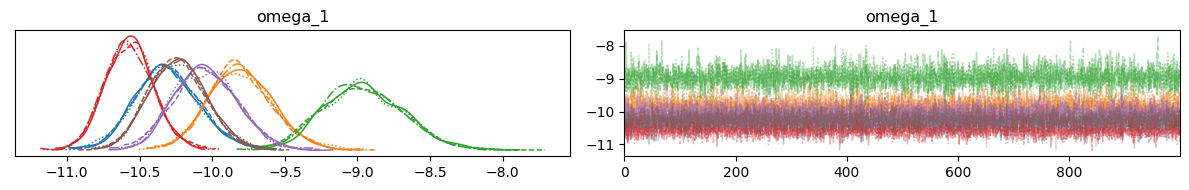

In [23]:
az.plot_trace(idata);
plt.tight_layout()

In [24]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
omega_1[0],-10.310,0.223,-10.727,-9.876,0.003,0.002,5907.0,3306.0,1.0
omega_1[1],-9.803,0.224,-10.211,-9.366,0.003,0.002,5013.0,3279.0,1.0
omega_1[2],-8.959,0.283,-9.460,-8.418,0.004,0.003,5353.0,2902.0,1.0
omega_1[3],-10.569,0.167,-10.884,-10.258,0.002,0.002,5960.0,3024.0,1.0
omega_1[4],-10.045,0.217,-10.428,-9.636,0.003,0.002,4863.0,3155.0,1.0
omega_1[5],-10.239,0.198,-10.598,-9.858,0.003,0.002,6132.0,3303.0,1.0


## Binary HGF

### Simulate a dataset

In [25]:
n_data = 10
dataset = []
for participant in range(n_data):
    input_data = []
    omega_2 = -1.0
    mu_2 = -1.0

    for i in range(1000):
        
        # x2
        pi_2 = np.exp(omega_2)
        mu_2 = np.random.normal(mu_2, pi_2**.5)

        # x1
        s2 = 1/(1+np.exp(-mu_2))  # sigmoid function
        u = np.random.binomial(n=1, p=s2)       
        input_data.append(u)

    dataset.append(input_data)

### Bayesian inference

In [26]:
hgf_logp_op = HGFDistribution(
    n_levels=2,
    model_type="binary",
    input_data=dataset,
    response_function=binary_surprise,
)

In [27]:
with pm.Model() as two_levels_binary_hgf:

    omega_2 = pm.Uniform("omega_2", -5.0, 0.0, shape=n_data)

    pm.Potential(
        "hgf_loglike",
        hgf_logp_op(
            omega_1=jnp.nan,
            omega_2=omega_2,
            omega_input=jnp.nan,
            rho_1=0.0,
            rho_2=0.0,
            pi_1=0.0,
            pi_2=1e4,
            mu_1=jnp.nan,
            mu_2=0.0,
            kappa_1=1.0,
            bias=0.0,
            omega_3=jnp.nan,
            rho_3=jnp.nan,
            pi_3=jnp.nan,
            mu_3=jnp.nan,
            kappa_2=jnp.nan
        ),
    )

#### Visualizing the model

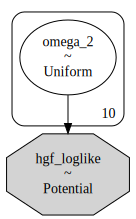

In [28]:
pm.model_to_graphviz(two_levels_binary_hgf)

#### Sampling

In [29]:
with two_levels_binary_hgf:
    two_level_hgf_idata = pm.sample(chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.


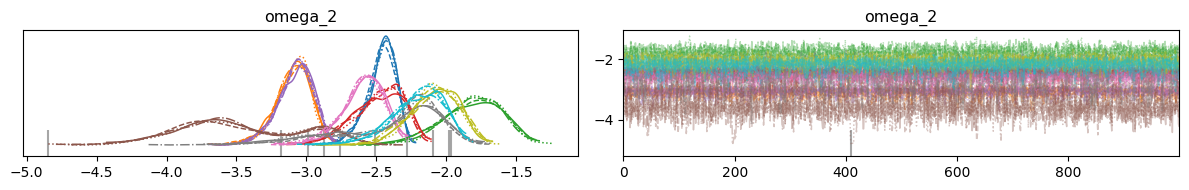

In [30]:
az.plot_trace(two_level_hgf_idata);
plt.tight_layout()

In [31]:
az.summary(two_level_hgf_idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
omega_2[0],-2.467,0.109,-2.680,-2.285,0.002,0.002,3083.0,1979.0,1.0
omega_2[1],-3.096,0.129,-3.339,-2.868,0.003,0.002,3153.0,1883.0,1.0
omega_2[2],-1.813,0.216,-2.217,-1.433,0.004,0.003,2999.0,2292.0,1.0
omega_2[3],-2.481,0.181,-2.820,-2.183,0.004,0.003,2900.0,2171.0,1.0
omega_2[4],-3.081,0.129,-3.329,-2.861,0.003,0.002,2834.0,1767.0,1.0
omega_2[5],-3.454,0.448,-4.171,-2.670,0.012,0.008,1688.0,2074.0,1.0
omega_2[6],-2.599,0.156,-2.894,-2.315,0.003,0.002,2796.0,1749.0,1.0
omega_2[7],-2.386,0.382,-3.158,-1.856,0.010,0.007,1891.0,2082.0,1.0
omega_2[8],-2.083,0.174,-2.400,-1.760,0.003,0.002,3298.0,2580.0,1.0
omega_2[9],-2.208,0.192,-2.564,-1.882,0.004,0.003,2633.0,1617.0,1.0
